In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os.path
import pretty_midi

### Generate ground truth labels

In [3]:
def importScoreInfo(scoreDir):
    d = {}
    for csvfile in glob.glob("{}/p*.scoreinfo.csv".format(scoreDir)):
        pieceStr = os.path.basename(csvfile).split('.')[0]  # e.g. 'p7'
        d[pieceStr] = {}
        with open(csvfile, 'r') as f:
            next(f) # skip header
            for line in f:
                parts = line.rstrip().split(',')
                linenum = int(parts[0])
                startmeasure = int(parts[1])
                endmeasure = int(parts[2])
                d[pieceStr][linenum] = (startmeasure, endmeasure)
    return d

In [4]:
scoreDir = 'data/score_info'
scoreInfo = importScoreInfo(scoreDir)

In [5]:
def importMidiInfo(midiInfoDir, midiDir):
    d = {}
    for csvfile in glob.glob("{}/p*_midinfo.csv".format(midiInfoDir)):
        pieceStr = os.path.basename(csvfile).split('_')[0]  # e.g. 'p7'
        d[pieceStr] = {}
        with open(csvfile, 'r') as f:
            for line in f:
                parts = line.rstrip().split(',')
                measure = int(parts[0])
                time = float(parts[1])
                d[pieceStr][measure] = time
        
        # add an additional entry to indicate the total duration
        midfile = "{}/{}.mid".format(midiDir, pieceStr)
        mid = pretty_midi.PrettyMIDI(midfile)
        totalDur = mid.get_piano_roll().shape[1] * .01 # default fs = 100
        d[pieceStr][measure+1] = totalDur
                
    return d

In [6]:
midiInfoDir = 'data/midi_info'
midiDir = 'data/midi'
midiInfo = importMidiInfo(midiInfoDir, midiDir)

/home/dyang/.conda/envs/MIR4/lib/python3.6/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


In [7]:
def getQueryGroundTruth(infile, multMatchFile, scoreInfo, midiInfo):
    # infers ground truth timestamps for each query
    d = {}
    with open(infile, 'r') as fin: 
        next(fin) # skip header
        for line in fin:

            # get start, end lines
            parts = line.rstrip().split(',')  # e.g. 'p1_q1,0,3'
            queryStr = parts[0]
            startLine = int(parts[1])
            endLine = int(parts[2])

            # infer start, end measure
            pieceStr = queryStr.split('_')[0]
            #print("%s,%s,%s" % (queryStr, startLine,endLine))            
            startMeasure = scoreInfo[pieceStr][startLine][0]
            endMeasure = scoreInfo[pieceStr][endLine][1]

            # infer start, end time
            #print("%s,%s,%s" % (queryStr, startMeasure, endMeasure))
            startTime = midiInfo[pieceStr][startMeasure]
            endTime = midiInfo[pieceStr][endMeasure+1] # ends on downbeat of next measure

            d[queryStr] = [(startTime, endTime, startMeasure, endMeasure, startLine, endLine)]

    addMultipleMatches(d, multMatchFile, scoreInfo, midiInfo)
            
    return d                

In [8]:
def addMultipleMatches(d, multMatchFile, scoreInfo, midiInfo):
    # some queries match more than 1 segment of the score, these are indicated in multMatchFile
    with open(multMatchFile, 'r') as f:
        for line in f:
            
            # parse line 
            parts = line.rstrip().split(',')  # e.g. 'p31_q8,L3m6,L5m1'
            queryStr = parts[0]
            pieceStr = queryStr.split('_')[0]
            startStr = parts[1]
            endStr = parts[2]
            
            # infer start, end measure
            startLine = int(startStr.split('m')[0][1:])
            endLine = int(endStr.split('m')[0][1:])
            startOffset = int(startStr.split('m')[1])
            endOffset = int(endStr.split('m')[1])
            startMeasure = scoreInfo[pieceStr][startLine][0] + startOffset - 1
            endMeasure = scoreInfo[pieceStr][endLine][0] + endOffset - 1
            
            # infer start, end time
            startTime = midiInfo[pieceStr][startMeasure]
            endTime = midiInfo[pieceStr][endMeasure+1] # ends on downbeat of next measure
            
            tup = (startTime, endTime, startMeasure, endMeasure, startStr, endStr) # startStr more informative than startLine
            d[queryStr].append(tup)
            
    return d

In [9]:
def saveQueryInfoToFile(d, outfile):
    with open(outfile, 'w') as f:
        for query in sorted(d):
            for (tstart, tend, mstart, mend, lstart, lend) in d[query]:
                f.write('{},{:.2f},{:.2f},{},{},{},{}\n'.format(query, tstart, tend, mstart, mend, lstart, lend))

In [10]:
queryInfoFile = 'data/query_info/query_info.csv' # to read
multMatchesFile = 'data/query_info/query.multmatches' # to read
queryGTFile = 'data/query_info/query.gt' # to write
queryInfo = getQueryGroundTruth(queryInfoFile, multMatchesFile, scoreInfo, midiInfo)
saveQueryInfoToFile(queryInfo, queryGTFile)

### Evaluate system performance

In [11]:
def readGroundTruthLabels(gtfile):
    d = {}
    with open(gtfile, 'r') as f:
        for line in f:
            parts = line.rstrip().split(',') # e.g. 'p1_q1,1.55,32.59'
            queryStr = parts[0]
            tstart = float(parts[1])
            tend = float(parts[2])
            if queryStr in d:
                d[queryStr].append((tstart, tend))
            else:
                d[queryStr] = [(tstart, tend)]
    return d

In [12]:
def readHypothesisFiles(hypdir):
    l = []
    for hypfile in sorted(glob.glob("{}/*.hyp".format(hypdir))):
        with open(hypfile, 'r') as f:
            line = next(f)
            parts = line.rstrip().split(',')
            query = parts[0]  # e.g. p1_q1
            tstart = float(parts[1])
            tend = float(parts[2])
            rank = int(parts[3])
            l.append((query, tstart, tend,rank))
    return l

In [13]:
def calcPrecisionRecall(hypdir, gtfile):
    d = readGroundTruthLabels(gtfile)
    hyps = readHypothesisFiles(hypdir)
    hypinfo = [] 
    overlapTotal, hypTotal, refTotal = (0,0,0)
    MRR = 0
    for (queryid, hypstart, hypend, rank) in hyps:
        MRR=MRR+1/(rank)
        refSegments = d[queryid]
        idxMax = 0
        overlapMax = 0
        for i, refSegment in enumerate(refSegments): # find ref segment with most overlap
            overlap = calcOverlap((hypstart, hypend), refSegment)
            if overlap > overlapMax:
                idxMax = i
                overlapMax = overlap
        hyplen = hypend - hypstart
        reflen = refSegments[idxMax][1] - refSegments[idxMax][0] 
        if rank!=1:
            overlapMax = 0
        overlapTotal += overlapMax
        hypTotal += hyplen
        refTotal += reflen
        hypinfo.append((queryid, overlapMax, refSegments[idxMax][0], refSegments[idxMax][1], idxMax)) # keep for error analysis
    P = overlapTotal / hypTotal
    R = overlapTotal / refTotal
    F = 2 * P * R / (P + R)
    return MRR/len(hyps), F, P, R, hypinfo

In [18]:
def calcOverlap(seg1, seg2):
    overlap_lb = max(seg1[0], seg2[0])
    overlap_ub = min(seg1[1], seg2[1])
    overlap = np.clip(overlap_ub - overlap_lb, 0, None)
    return overlap    

In [19]:
hypdir = 'experiments/train/hyp'
MRR, F, P, R, hypinfo = calcPrecisionRecall(hypdir, queryGTFile)

In [20]:
MRR, F, P, R, len(hypinfo)

(0.9136183376322606,
 0.898949893356236,
 0.9395551251399697,
 0.8617089781081875,
 390)

### Investigate Errors

In [37]:
def printDebuggingInfo(hypdir, gtfile, scoreInfo, midiInfo, queryInfo, hypInfo):
    d = readGroundTruthLabels(gtfile)
    hyps = readHypothesisFiles(hypdir)
    for i, (query, hyp_tstart, hyp_tend) in enumerate(hyps):
        
        # hyp and ref info (sec)
        piece = query.split('_')[0]
        _, overlap, ref_tstart, ref_tend, bestIdx = hypInfo[i]
        
        # hyp and ref info (measures)
        interp_m = list(midiInfo[piece].keys())
        interp_t = [midiInfo[piece][m] for m in interp_m]
        hyp_mstart, hyp_mend, ref_mstart, ref_mend = np.interp([hyp_tstart, hyp_tend, ref_tstart, ref_tend], interp_t, interp_m)
        moverlap = calcOverlap((hyp_mstart, hyp_mend),(ref_mstart, ref_mend))
        
        # hyp and ref info (line # + measure offset)
        hyp_lstart, hyp_lstartoff = getLineNumberMeasureOffset(hyp_mstart, scoreInfo[piece])
        hyp_lend, hyp_lendoff = getLineNumberMeasureOffset(hyp_mend, scoreInfo[piece])
        ref_lstart = queryInfo[query][bestIdx][4]
        ref_lend = queryInfo[query][bestIdx][5]
        
        # compare in sec
        print("{}: hyp ({:.1f} s,{:.1f} s), ref ({:.1f} s,{:.1f} s), overlap {:.1f} of {:.1f} s".format(query, hyp_tstart, hyp_tend, ref_tstart, ref_tend, overlap, ref_tend - ref_tstart))
        
        # compare in measure numbers
        #print("\thyp ({:.1f} m, {:.1f} m), ref ({:.1f} m, {:.1f} m), overlap {:.1f} m".format(hyp_mstart, hyp_mend, ref_mstart, ref_mend, moverlap))
        
        # compare in line + measure offset
        print("\thyp (ln {} m{:.1f}, ln {} m{:.1f}), ref (ln {}, ln {})".format(hyp_lstart, hyp_lstartoff, hyp_lend, hyp_lendoff, ref_lstart, ref_lend))
    return

In [38]:
def getLineNumberMeasureOffset(measureNum, d):
    line = -1
    moffset = -1
    for key in d:
        lb, ub = d[key] # line start, end measure 
        if measureNum >= lb and measureNum < ub + 1:
            line = key
            moffset = measureNum - lb + 1
            break
    return line, moffset

In [39]:
printDebuggingInfo(hypdir, queryGTFile, scoreInfo, midiInfo, queryInfo, hypinfo)

ValueError: too many values to unpack (expected 3)

### Measure Runtime

In [42]:
def showRuntimeStats(indir):
    durs = []
    cnt = 0
    for hypfile in glob.glob('{}/*.hyp'.format(indir)):
        cnt += 1
        with open(hypfile, 'r') as f:
            line = next(f)
            parts = line.split(',')
            dur = float(parts[4])
            durs.append(dur)
    durs = np.array(durs)
    avgDur = np.mean(durs)
    minDur = np.min(durs)
    maxDur = np.max(durs)
    stdDur = np.std(durs)
    print('{} files'.format(cnt))
    print('Avg Duration: {:.2f} sec'.format(avgDur))
    print('Std Duration: {:.2f} sec'.format(stdDur))
    print('Min Duration: {:.2f} sec'.format(minDur))
    print('Max Duration: {:.2f} sec'.format(maxDur))
    plt.hist(durs, bins=np.arange(0,2,.1))
    plt.xlabel('Runtime (sec)')
    plt.ylabel('Count')

2000 files
Avg Duration: 8.98 sec
Std Duration: 2.73 sec
Min Duration: 0.60 sec
Max Duration: 22.14 sec


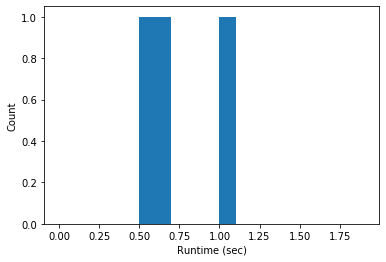

In [43]:
showRuntimeStats(hypdir)